# Run inference on one frame
Then evaluate

In [1]:
from mmdet3d.apis import LidarDet3DInferencer
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Initialize inferencer
inferencer = LidarDet3DInferencer('pointpillars_kitti-3class')

/home/rachel/mmdetection3d/mmdet3d/models/dense_heads/anchor3d_head.py:94: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection3d/v1.0.0_models/pointpillars/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class_20220301_150306-37dc2420.pth
09/04 13:30:20 - mmengine - WARNING - Failed to search registry with scope "mmdet3d" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet3d" is a correct scope, or whether the registry is initialized.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/rachel/miniconda3/envs/openmm_mmvc/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [3]:
# inference
frame = '006000'
bin_path = '../../mmdetection3d/data/arcs/training/velodyne/' + frame + '.bin'
label_path = '../data/pillar_pred_format_labels/' + frame + '.txt'
inputs = dict(points=bin_path)
points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
predictions = inferencer(inputs)

Output()

/home/rachel/miniconda3/envs/openmm_mmvc/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: 
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at
/opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

In [4]:
print(predictions)

{'predictions': [{'labels_3d': [1, 2, 2, 2, 2, 2], 'scores_3d': [0.37436285614967346, 0.8860181570053101, 0.846523106098175, 0.5451850891113281, 0.4473717212677002, 0.4247516095638275], 'bboxes_3d': [[5.028863430023193, -15.78142261505127, -0.721443772315979, 1.7926948070526123, 0.6943190097808838, 1.7274187803268433, 1.5951296091079712], [2.158820867538452, 25.521644592285156, -2.0219573974609375, 4.410659313201904, 1.713751196861267, 1.4779202938079834, -1.0621992349624634], [10.126334190368652, 26.06059455871582, -1.8438267707824707, 4.386297225952148, 1.6843407154083252, 1.5065099000930786, 2.106016159057617], [29.500598907470703, -14.849691390991211, 0.2762340307235718, 4.206188201904297, 1.5862056016921997, 1.5070021152496338, 2.1125431060791016], [28.044879913330078, -20.803447723388672, 0.47694647312164307, 4.386697292327881, 1.6085255146026611, 1.3169963359832764, 1.2406989336013794], [31.531211853027344, -25.256420135498047, 0.4247567653656006, 4.498119831085205, 1.6615589857

In [5]:
def set_axes_limited(ax, limit=50):
    # Set axes to a fixed range around the origin to limit view to +/- 'limit' meters.
    ax.set_xlim3d([-limit, limit])
    ax.set_ylim3d([-limit, limit])
    ax.set_zlim3d([-limit, limit])

In [6]:
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres, cubes as cubes, etc."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [7]:
# Function to plot the bounding box
def plot_bbox(ax, bbox, color):
    
    x, y, z, dx, dy, dz, yaw = bbox

    
    corners = np.array([
        [x - dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y + dy/2, z + dz/2],
        [x - dx/2, y + dy/2, z + dz/2]
    ])
    

    # Rotate corners around the Z-axis (around their centers)
    rotation_matrix = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,            0,           1]
    ])

    # # Adjust the corners to be about the origin for rotation, then add the [x, y, z] back after rotation
    corners = corners - np.array([x, y, z])
    corners = np.dot(corners, rotation_matrix.T)
    corners += np.array([x, y, z])
    
    # Define the edges of the bounding box
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    # Plot the edges
    for edge in edges:
        ax.plot3D(*zip(corners[edge[0]], corners[edge[1]]), color=color, linewidth=1)

In [8]:
def read_kitti_labels(label_path):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] != 'DontCare':
                bbox = [float(value) for value in parts[8:15]]  # Extract the bounding box dimensions and location
                bboxes.append(bbox)
    print(bboxes)
    return np.array(bboxes)

In [9]:
def rotate_point(point, angle):
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    return np.dot(R, point)

In [10]:
# This function should convert the x, y, z, length, width, height, yaw values
# into 8 corner points (which is the format needed to computer IoU with the pytorch3d library)
def get_box_corners(x, y, z, length, width, height, yaw):
    corners = np.array([
        [length/2, width/2, height/2],
        [length/2, width/2, -height/2],
        [length/2, -width/2, height/2],
        [length/2, -width/2, -height/2],
        [-length/2, width/2, height/2],
        [-length/2, width/2, -height/2],
        [-length/2, -width/2, height/2],
        [-length/2, -width/2, -height/2]
    ])
    rotated_corners = np.array([rotate_point(corner, yaw) for corner in corners])
    translated_corners = rotated_corners + np.array([x, y, z])
#     print(translated_corners)
    return translated_corners

# Example usage
# x, y, z = 0, 0, 0
# length, width, height, yaw = 4, 2, 1, np.pi/4  # yaw in radians
# corners = get_box_corners(x, y, z, length, width, height, yaw)
# print("Corners:\n", corners)

[[2.26, 25.69, -1.4, 2.46, 5.19, 2.55, 0.53], [2.12, 32.9, -1.55, 2.15, 5.67, 2.57, 3.67], [10.2, 26.15, -1.04, 2.12, 4.7, 2.56, 3.63], [29.43, -14.69, 1.3, 2.32, 5.03, 2.64, 3.67]]


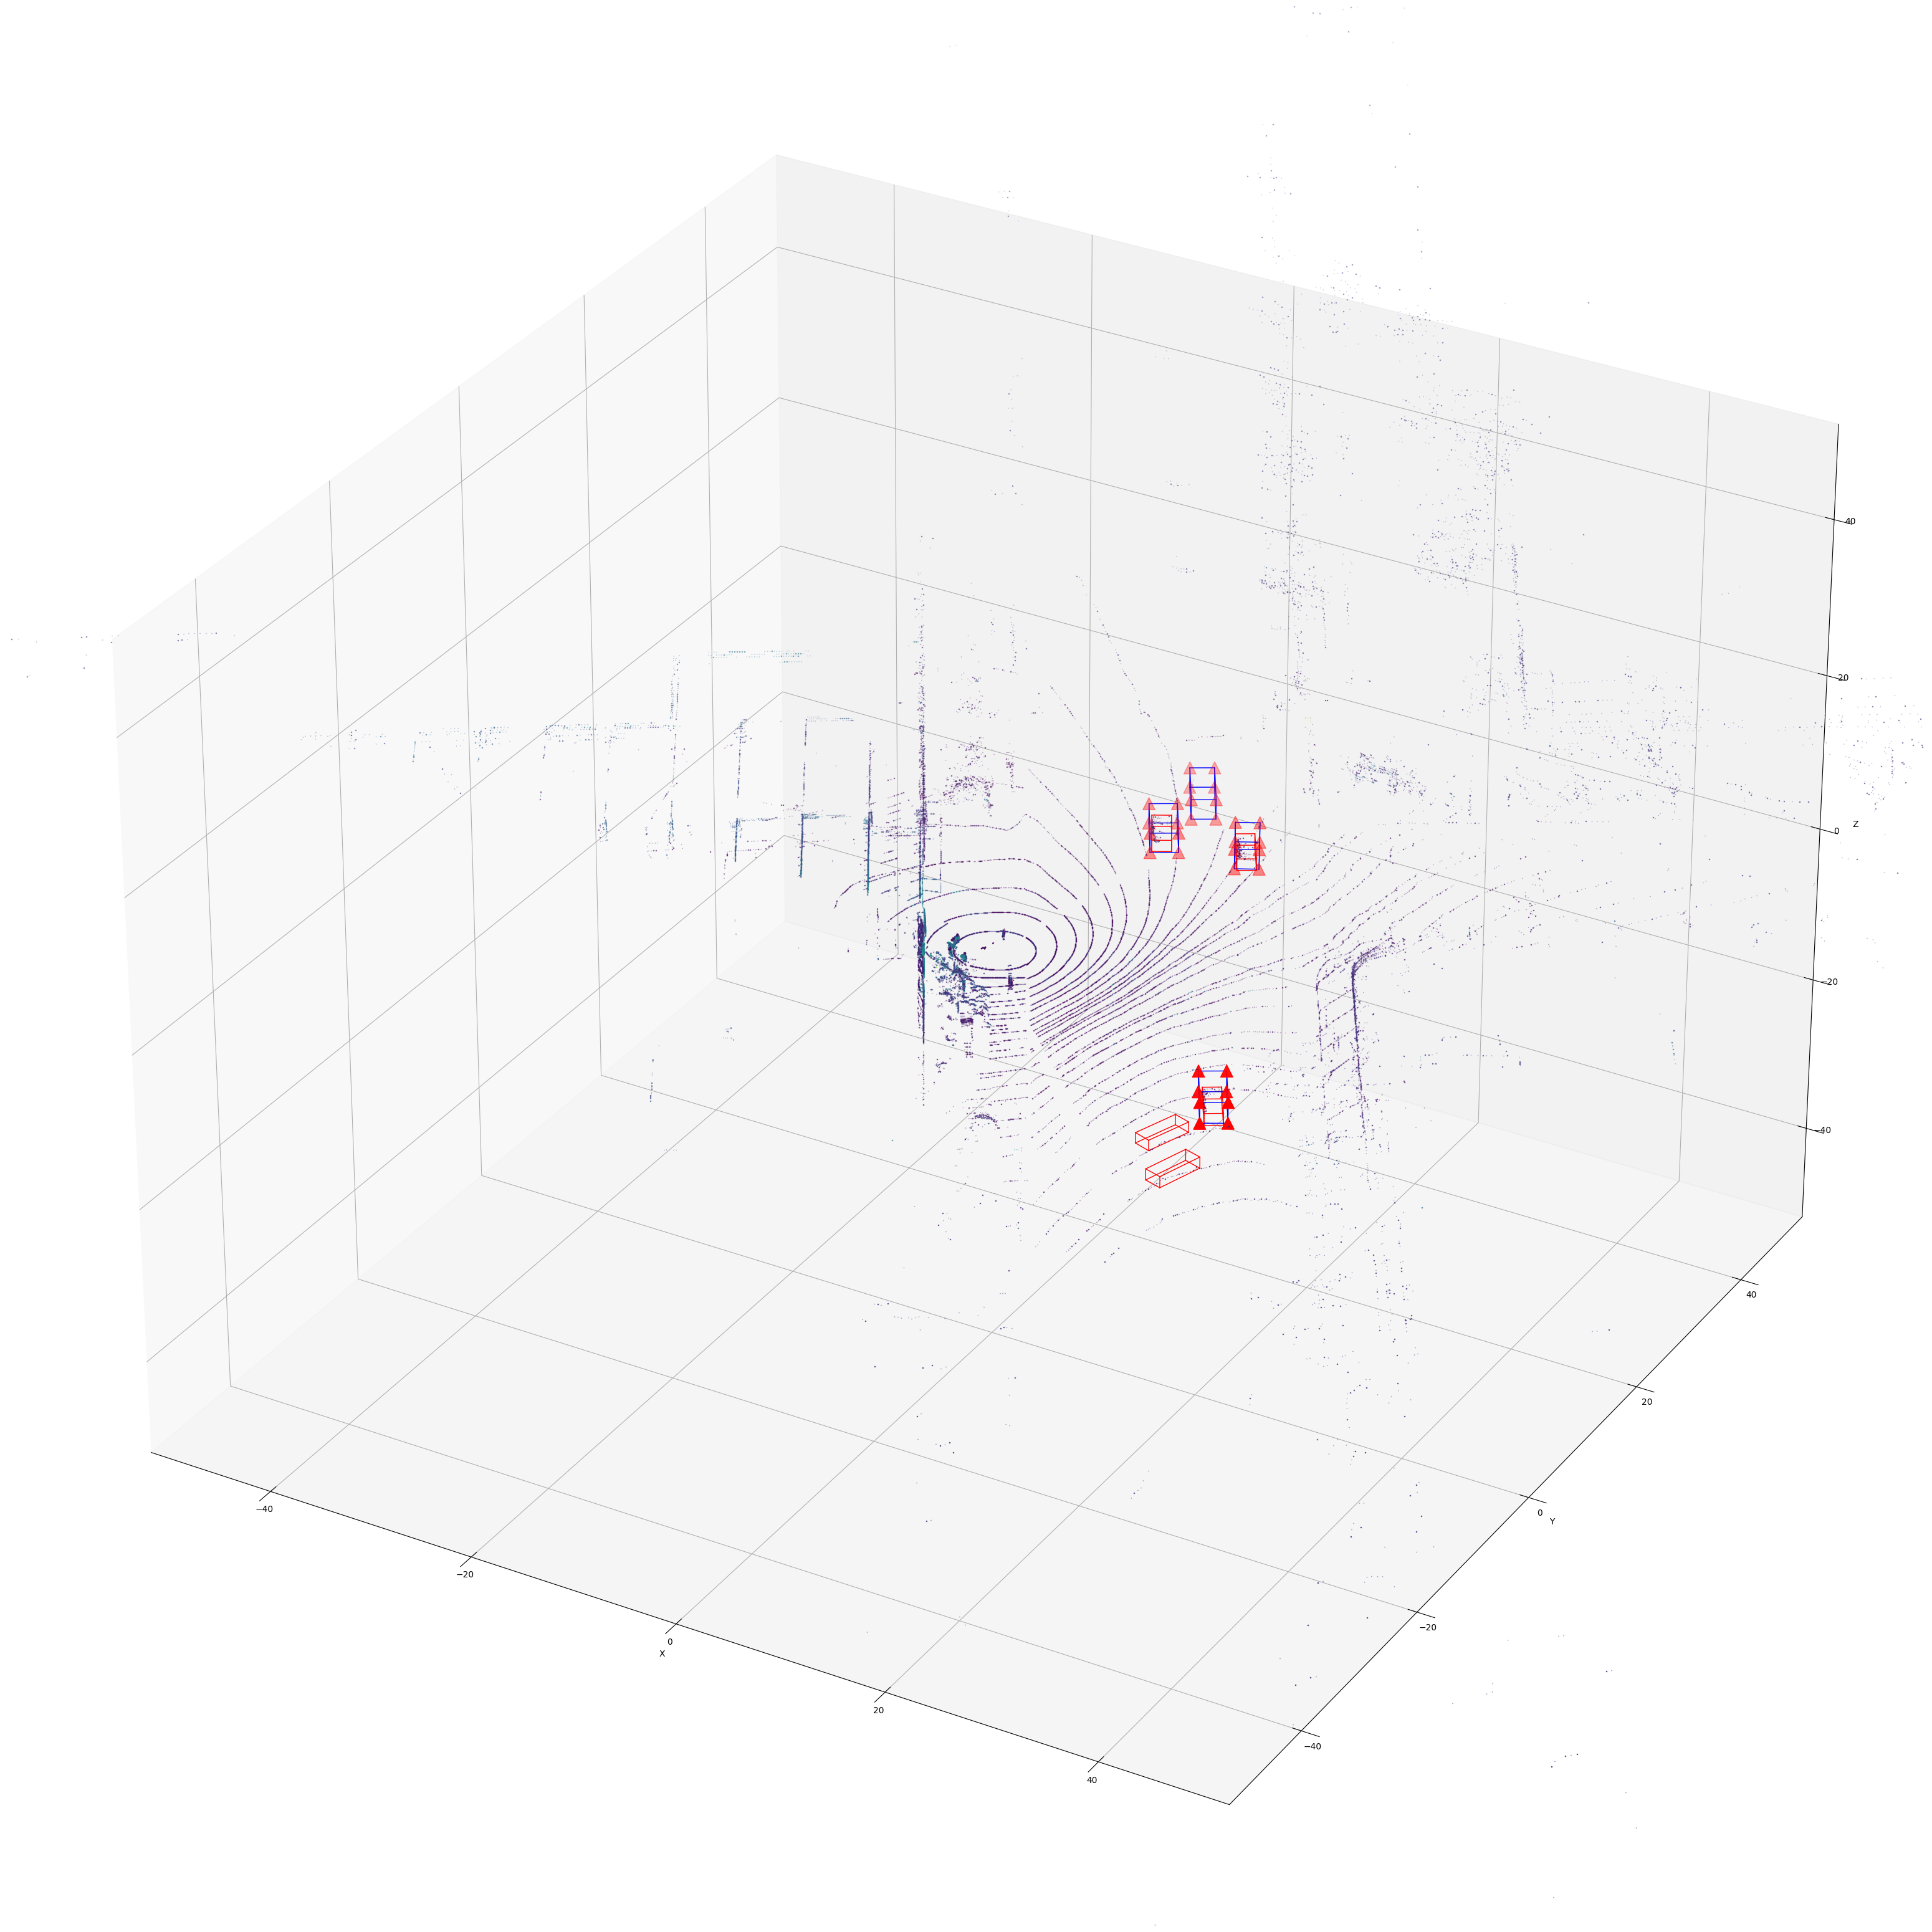

In [11]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, c=points[:, 3], cmap='viridis', marker=',')

score_threshold = 0.23

# Plot each bounding box with score above threshold
for pred in predictions['predictions']:
    for label, score, bbox in zip(pred['labels_3d'], pred['scores_3d'], pred['bboxes_3d']):
        if score > score_threshold and label == 2:
            plot_bbox(ax, bbox, 'r')
            
corner_points = []
# Plot ground truth
for bbox in read_kitti_labels(label_path):
    # And corners points to list(to check that that function is working)
    corners = get_box_corners(bbox[0], bbox[1], bbox[2], bbox[3], bbox[4], bbox[5], bbox[6])
    for corner in corners:
        corner_points.extend(corner)
    plot_bbox(ax, bbox, 'b')
    
# Plot corners
# print(corner_points)
corner_points_np = np.array(corner_points).reshape(-1, 3)
ax.scatter(corner_points_np[:, 0], corner_points_np[:, 1], corner_points_np[:, 2], s=200, c='r', marker='^')
            
# Setting axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)

# Setting axes properties with a limited range
set_axes_limited(ax)

# Show the plot
plt.show()

# Save the figure
fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

## Try to get the IoU with pytorch3d

In [12]:
# Would be incompatible with the version of pytorch and could mess up my mmdetection3d environmentabs

## Try bbox library

In [13]:
import bbox
import math

In [14]:
# The 3D bbox object requires quaternion values. This function converts the yaw to these values
def yaw_to_quaternion(yaw):
    """
    Converts a yaw angle (rotation about the z-axis) to quaternion coordinates.
    
    Parameters:
    - yaw (float): The yaw angle in radians.
    
    Returns:
    - tuple of (rw, rx, ry, rz): The quaternion representation of the yaw.
    """
    # Compute the components of the quaternion
    rw = math.cos(yaw / 2.0)
    rz = math.sin(yaw / 2.0)
    
    # rx and ry are zero because the rotation is only about the z-axis
    return (rw, 0, 0, rz)

In [15]:
# This function takes x, y, z, dx, dy, dz, yaw and returns a 3D bbox object from the bbox package
# Yaw is in radians
def get3DBbox(x, y, z, dx, dy, dz, yaw):
    # Example usage:
    rw, rx, ry, rz = yaw_to_quaternion(yaw)
    bbox_obj = bbox.BBox3D(x, y, z, length=dx, width=dy, height=dz, rw=rw, rx=rx, ry=ry, rz=rz)
    return bbox_obj

In [16]:
bbox_label = get3DBbox(2.26, 25.69, -1.4, 2.46, 5.19, 2.55, 0.53)
bbox_pred_0 = get3DBbox(5.028863430023193, -15.78142261505127, -0.721443772315979, 
                        1.7926948070526123, 0.6943190097808838, 1.7274187803268433, 1.5951296091079712)
print(bbox.metrics.jaccard_index_3d(bbox_label, bbox_pred_0))

bbox_pred_1 = get3DBbox(2.158820867538452, 25.521644592285156, -2.0219573974609375, 
                        4.410659313201904, 1.713751196861267, 1.4779202938079834, -1.0621992349624634)
print(bbox.metrics.jaccard_index_3d(bbox_label, bbox_pred_1))


bbox_pred_2 = get3DBbox(10.126334190368652, 26.06059455871582, -1.8438267707824707, 
                        4.386297225952148, 1.6843407154083252, 1.5065099000930786, 2.106016159057617)
print(bbox.metrics.jaccard_index_3d(bbox_label, bbox_pred_2))


bbox_pred_3 = get3DBbox(29.500598907470703, -14.849691390991211, 0.2762340307235718, 
                        4.206188201904297, 1.5862056016921997, 1.5070021152496338, 2.1125431060791016)
print(bbox.metrics.jaccard_index_3d(bbox_label, bbox_pred_3))


bbox_pred_4 = get3DBbox(28.044879913330078, -20.803447723388672, 0.47694647312164307, 
                        4.386697292327881, 1.6085255146026611, 1.3169963359832764, 1.2406989336013794)
print(bbox.metrics.jaccard_index_3d(bbox_label, bbox_pred_4))


bbox_pred_5 = get3DBbox(31.531211853027344, -25.256420135498047, 0.4247567653656006, 
                        4.498119831085205, 1.661558985710144, 1.4026427268981934, 4.414409637451172)
print(bbox.metrics.jaccard_index_3d(bbox_label, bbox_pred_5))

0
0.34313
0
0
0
0


In [17]:
def calculate_iou(bbox1, bbox2):
    bbox_obj1 = get3DBbox(*bbox1)
    bbox_obj2 = get3DBbox(*bbox2)
    return bbox.metrics.jaccard_index_3d(bbox_obj1, bbox_obj2)

In [18]:
# def parse_predictions(prediction):
#     return prediction

In [19]:
def parse_ground_truths(label_path):
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            bbox = []
            # Add the category as a string
            bbox.append(parts[0])
            # Extract the bounding box dimensions and location as 
            bbox = bbox + [float(value) for value in parts[1:15]]  
            bbox[2] = int(bbox[2])
            labels.append(bbox)
    return labels

In [30]:
def evaluate_model(predictions, ground_truths, threshold=0.5):
    TPs, FPs, FNs = 0, 0, len(ground_truths)
    used_gt = set()
    
    for pred in predictions['predictions']:
        for label, score, bbox in zip(pred['labels_3d'], pred['scores_3d'], pred['bboxes_3d']):
            if score < threshold:
                continue
        
            best_iou = 0
            best_gt = None
            for gt in ground_truths:
                iou = calculate_iou(bbox, gt[8:])
                print(iou)
                if iou > best_iou:
                    best_iou = iou
                    best_gt = tuple(gt)

            if best_iou > 0.25:  # Example IoU threshold for a match
                if best_gt not in used_gt:
                    used_gt.add(best_gt)
                    TPs += 1
                    FNs -= 1
                else:
                    FPs += 1
            else:
                FPs += 1

    precision = TPs / (TPs + FPs) if TPs + FPs > 0 else 0
    recall = TPs / (TPs + FNs) if TPs + FNs > 0 else 0
    return precision, recall

In [31]:
# Example usage
# predictions = parse_predictions(predictions)
ground_truths = parse_ground_truths(label_path)
precision, recall = evaluate_model(predictions, ground_truths)

0.34313
0
0
0
0
0
0.43634
0
0
0
0
0.32636


In [32]:
print(precision)
print(recall)

1.0
0.75


In [23]:
# def calculate_iou(box_pred, box_gt):
#     # Determine the coordinates of the intersection rectangle
#     xA = max(box_pred[0], box_gt[0])
#     yA = max(box_pred[1], box_gt[1])
#     zA = max(box_pred[2], box_gt[2])
#     xB = min(box_pred[3], box_gt[3])
#     yB = min(box_pred[4], box_gt[4])
#     zB = min(box_pred[5], box_gt[5])
    
#     # Compute the volume of intersection
#     interWidth = max(0, xB - xA)
#     interHeight = max(0, yB - yA)
#     interDepth = max(0, zB - zA)
#     interVolume = interWidth * interHeight * interDepth
    
#     # Compute the volume of both the prediction and ground truth boxes
#     boxAVolume = (box_pred[3] - box_pred[0]) * (box_pred[4] - box_pred[1]) * (box_pred[5] - box_pred[2])
#     boxBVolume = (box_gt[3] - box_gt[0]) * (box_gt[4] - box_gt[1]) * (box_gt[5] - box_gt[2])
    
#     # Compute the union volume
#     unionVolume = boxAVolume + boxBVolume - interVolume
    
#     # Compute the intersection over union by taking the intersection
#     # volume and dividing it by the union volume
#     iou = interVolume / unionVolume
    
#     return iou

In [24]:
# from scipy.spatial import ConvexHull

In [25]:
# def rotate_vertices(vertices, yaw, center):
#     c, s = np.cos(yaw), np.sin(yaw)
#     R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])  # Rotation matrix for z-axis
#     rotated_vertices = np.dot(vertices - center, R.T) + center
#     return rotated_vertices

In [26]:
# def get_box_vertices(x, y, z, dx, dy, dz, yaw):
#     half_dx = dx / 2.0
#     half_dy = dy / 2.0
#     half_dz = dz / 2.0
#     corners = np.array([
#         [x + half_dx, y + half_dy, z + half_dz],
#         [x + half_dx, y + half_dy, z - half_dz],
#         [x + half_dx, y - half_dy, z + half_dz],
#         [x + half_dx, y - half_dy, z - half_dz],
#         [x - half_dx, y + half_dy, z + half_dz],
#         [x - half_dx, y + half_dy, z - half_dz],
#         [x - half_dx, y - half_dy, z + half_dz],
#         [x - half_dx, y - half_dy, z - half_dz]
#     ])
#     center = np.array([x, y, z])
#     return rotate_vertices(corners, yaw, center)

In [27]:
# def calculate_iou(boxA_params, boxB_params):
#     verticesA = get_box_vertices(*boxA_params)
#     verticesB = get_box_vertices(*boxB_params)
    
#     print(verticesA)
#     print(verticesB)

#     # Creating a convex hull of the combined set of vertices
#     all_points = np.vstack([verticesA, verticesB])
#     hull = ConvexHull(all_points)

#     # Calculate volumes
#     volume_intersection = ConvexHull(np.vstack([verticesA, verticesB[hull.vertices]])).volume
#     volume_union = ConvexHull(all_points).volume + ConvexHull(verticesA).volume + ConvexHull(verticesB).volume - volume_intersection

#     iou = volume_intersection / volume_union
#     return iou